# DS-NYC-45 | Unit Project 3: Basic Machine Learning Modeling

In this project, you will perform a logistic regression on the admissions data we've been working with in Unit Projects 1 and 2.

In [1]:
import os
import numpy as np
import pandas as pd
import pylab as pl
import statsmodels.formula.api as smf
from sklearn import linear_model

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.notebook_repr_html', True)

In [2]:
df = pd.read_csv(os.path.join('..', '..', 'dataset', 'ucla-admissions.csv'))
df.head()

,admit,gre,gpa,prestige
0,0,380.0,3.61,3.0
1,1,660.0,3.67,3.0
2,1,800.0,4.00,1.0
3,1,640.0,3.19,4.0
4,0,520.0,2.93,4.0


In [3]:
df.dropna(inplace = True)
df.describe()

,admit,gre,gpa,prestige
count,397.000000,397.000000,397.000000,397.000000
mean,0.317380,587.858942,3.392242,2.488665
std,0.466044,115.717787,0.380208,0.947083
min,0.000000,220.000000,2.260000,1.000000
25%,0.000000,520.000000,3.130000,2.000000
50%,0.000000,580.000000,3.400000,2.000000
75%,1.000000,660.000000,3.670000,3.000000
max,1.000000,800.000000,4.000000,4.000000


## Part A.  Frequency Table

> ### Question 1.  Create a frequency table for `prestige` and whether or not an applicant was admitted.

In [4]:
pd.crosstab(df['admit'], df['prestige'], rownames=['admit'])

prestige,1.0,2.0,3.0,4.0
admit,,,,
0,28,95,93,55
1,33,53,28,12


## Part B.  Variable Transformations

> ### Question 2.  Create a one-hot encoding for `prestige`.

In [5]:
dum = pd.get_dummies(df['prestige'])
frames = (df, dum)
df2 = pd.concat(frames, axis=1)
df2

,admit,gre,gpa,prestige,1.0,2.0,3.0,4.0
0,0,380.0,3.61,3.0,0.0,0.0,1.0,0.0
1,1,660.0,3.67,3.0,0.0,0.0,1.0,0.0
2,1,800.0,4.00,1.0,1.0,0.0,0.0,0.0
3,1,640.0,3.19,4.0,0.0,0.0,0.0,1.0
4,0,520.0,2.93,4.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
395,0,620.0,4.00,2.0,0.0,1.0,0.0,0.0
396,0,560.0,3.04,3.0,0.0,0.0,1.0,0.0
397,0,460.0,2.63,2.0,0.0,1.0,0.0,0.0
398,0,700.0,3.65,2.0,0.0,1.0,0.0,0.0


> ### Question 3.  How many of these binary variables do we need for modeling?

Answer:

We need max-1 - which, in this case is 4-1 --> 3 dummy variables

> ### Question 4.  Why are we doing this?

Answer:

We want to use linear regression, but since the prestige of schools is a qualitative measure (high, med-high, med-low, low or 1, 2, 3, 4) we need to transform them to values that can be binary (i.e. yes/no, quantitative). 

As to why we are dropping one of the four columns: it is not needed, because when the three (p2, p3, p4) are zero is the same as p1 = 1.  This way we prevent multicollinearity, or the 'dummy variable trap'.

> ### Question 5.  Add all these binary variables in the dataset and remove the now redundant `prestige` feature.

In [6]:
del df2['prestige']

In [7]:
df2.head()

,admit,gre,gpa,1.0,2.0,3.0,4.0
0,0,380.0,3.61,0.0,0.0,1.0,0.0
1,1,660.0,3.67,0.0,0.0,1.0,0.0
2,1,800.0,4.00,1.0,0.0,0.0,0.0
3,1,640.0,3.19,0.0,0.0,0.0,1.0
4,0,520.0,2.93,0.0,0.0,0.0,1.0


## Part C.  Hand calculating odds ratios

Let's develop our intuition about expected outcomes by hand calculating odds ratios.

> ### Question 6.  Create a frequency table for `prestige = 1` and whether or not an applicant was admitted.

In [8]:
pd.crosstab(df2['admit'], df2[1.0], rownames=['admit'])

1.0,0.0,1.0
admit,,
0,243,28
1,93,33


> ### Question 7.  Use the frequency table above to calculate the odds of being admitted to graduate school for applicants that attended the most prestigious undergraduate schools.

In [9]:
# Finding number of prestige=1 applicants
df_p1 = df2.where(df2[1.0] == 1).dropna()
p1_applied = float(len(df_p1))
print "Number of Prestige=1 applicants: " + str(p1_applied)

Number of Prestige=1 applicants: 61.0


In [10]:
# Of all the prestige=1 applicants, this many were admitted
p1_admitted = float(len(df_p1.where(df_p1['admit'] == 1).dropna()))
print "Number of Prestige=1 admitted: " + str(p1_admitted)

Number of Prestige=1 admitted: 33.0


In [11]:
# The probability that a prestige=1 applicant was gets accepted is
prob_p1_admit = p1_admitted / p1_applied
prob_p1_admit
print("The probability for a Prestige=1 applicant to be accepted is: " + "{0:.3}%".format((p1_admitted/p1_applied)*100))

The probability for a Prestige=1 applicant to be accepted is: 54.1%


In [12]:
# odds = probability / (1 - probability)
odds_p1_admit = prob_p1_admit / (1 - prob_p1_admit)
print "The odds for a Prestige=1 applicant to be accepted are: " + str("{0:.3}".format(odds_p1_admit))

The odds for a Prestige=1 applicant to be accepted are: 1.18


> ### Question 8.  Now calculate the odds of admission for undergraduates who did not attend a #1 ranked college.

In [13]:
# Looking for no. of applicants from Prestige-2, Prestige-3, or Prestige-4 schools
df_p234 = df2.where((df2[2.0] == 1) | (df2[3.0] == 1) | (df2[4.0] == 1)).dropna()
p234_applied = float(len(df_p234))
p234_applied

336.0

In [14]:
# Of all the (prestige=2 or =3 or =4) applicants, this many were admitted
p234_admitted = float(len(df_p234.where(df_p234['admit'] == 1).dropna()))
p234_admitted

93.0

In [15]:
# The probability that a (prestige=2 or =3 or =4) applicant was accepted is
p234_admit_prob = p234_admitted / p234_applied
print("{0:.3}%".format((p234_admitted/p234_applied)*100))

27.7%


In [16]:
p234_odds = p234_admit_prob / (1 - p234_admit_prob)
print("{0:.2}".format(p234_odds))

0.38


> ### Question 9.  Finally, what's the odds ratio?

In [17]:
p1_to_p234_odds_ratio = odds_p1_admit / p234_odds
print("{0:.3}".format(p1_to_p234_odds_ratio))

3.08


> ### Question 10.  Write this finding in a sentenance.

Answer:

Applicants who went to a p1 school have three times the odds of applicants who went to schools other than p1

> ### Question 11.  Use the frequency table above to calculate the odds of being admitted to graduate school for applicants that attended the least prestigious undergraduate schools.  Then calculate their odds ratio of being admitted to UCLA.  Finally, write this finding in a sentenance.

In [18]:
# Finding number of prestige=4 applicants
df_p4 = df2.where(df2[4.0] == 1).dropna()
p4_applied = float(len(df_p4))
p4_applied

67.0

In [19]:
# Of all the prestige=4 applicants, this many were admitted
p4_admitted = float(len(df_p4.where(df_p4['admit'] == 1).dropna()))
p4_admitted

12.0

In [20]:
p4_not_admitted = p4_applied - p4_admitted
p4_not_admitted

55.0

In [21]:
# The probability that a prestige=4 applicant gets accepted is
p4_admit_prob = p4_admitted / p4_applied
print("{0:.3}%".format((p4_admitted/p4_applied)*100))

17.9%


In [22]:
p4_not_admit_prob = 1 - p4_admit_prob
print "{0:.3}%".format((p4_not_admit_prob*100))

82.1%


In [23]:
# The odds that a prestige=4 applicant gets accepted is
p4_admit_odds = p4_admit_prob / (1 - p4_admit_prob)
print("The odds for a Prestige=4 applicant to be admitted are " + "{0:.2}".format(p4_admit_odds))

The odds for a Prestige=4 applicant to be admitted are 0.22


In [24]:
# The odds that a prestige=4 applicant does not get accepted is
p4_not_admit_odds = p4_not_admit_prob / (1 - p4_not_admit_prob)
print("The odds that a Prestige=4 applicant is rejected are " + "{0:.3}".format(p4_not_admit_odds))

The odds that a Prestige=4 applicant is rejected are 4.58


Answer: This means that the odds of a p4 applicant are (0.22):(4.6) --> approx 25 times more likely not to get accepted than to get accepted

## Part C. Analysis using `statsmodels`

> ### Question 12.  Fit a logistic regression model prediting admission into UCLA using `gre`, `gpa`, and the prestige of the undergraduate schools.  Use the highest prestige undergraduate schools as your reference point.

In [25]:
df.describe()

,admit,gre,gpa,prestige
count,397.000000,397.000000,397.000000,397.000000
mean,0.317380,587.858942,3.392242,2.488665
std,0.466044,115.717787,0.380208,0.947083
min,0.000000,220.000000,2.260000,1.000000
25%,0.000000,520.000000,3.130000,2.000000
50%,0.000000,580.000000,3.400000,2.000000
75%,1.000000,660.000000,3.670000,3.000000
max,1.000000,800.000000,4.000000,4.000000


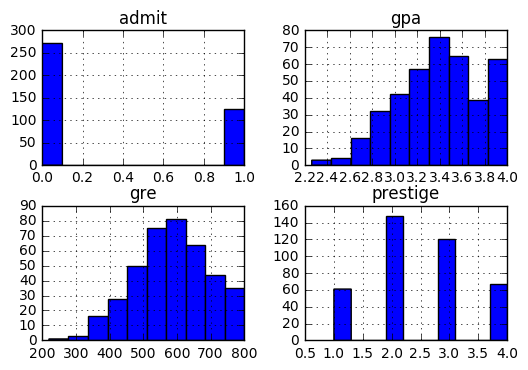

In [26]:
df.hist()
pl.show()

In [27]:
# Adding the intercept to the df2 dataframe - df2 is the one with the dummy variables
df2['intercept'] = 1.0
df2.head()

,admit,gre,gpa,1.0,2.0,3.0,4.0,intercept
0,0,380.0,3.61,0.0,0.0,1.0,0.0,1.0
1,1,660.0,3.67,0.0,0.0,1.0,0.0,1.0
2,1,800.0,4.00,1.0,0.0,0.0,0.0,1.0
3,1,640.0,3.19,0.0,0.0,0.0,1.0,1.0
4,0,520.0,2.93,0.0,0.0,0.0,1.0,1.0


In [28]:
train_cols = ['gre', 'gpa', 2.0, 3.0, 4.0, 'intercept']
logit = smf.Logit(df2['admit'], df2[train_cols])
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.573854
         Iterations 6


> ### Question 13.  Print the model's summary results.

In [29]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                  397
Model:                          Logit   Df Residuals:                      391
Method:                           MLE   Df Model:                            5
Date:                Tue, 17 Jan 2017   Pseudo R-squ.:                 0.08166
Time:                        12:14:49   Log-Likelihood:                -227.82
converged:                       True   LL-Null:                       -248.08
                                        LLR p-value:                 1.176e-07
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
gre            0.0022      0.001      2.028      0.043      7.44e-05     0.004
gpa            0.7793      0.333      2.344      0.019         0.128     1.431
2.0           -0.6801      0.317     -2.146      0.032        -1.301    -0.059
3.0           -1.3387      0.345     -3.882      0.000        -2.015    -0.663
4.0           -1.5534      0.417     -3.721      0.000        -2.372    -0.735
intercept     -3.8769      1.142     -3.393      0.001        -6.116    -1.638
==============================================================================
"""

> ### Question 14.  What are the odds ratios of the different features and their 95% confidence intervals?

In [30]:
result.conf_int()

,0,1
gre,0.000074,0.004362
gpa,0.127619,1.431056
2.0,-1.301337,-0.058936
3.0,-2.014579,-0.662776
4.0,-2.371624,-0.735197
intercept,-6.116077,-1.637631


In [31]:
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
np.exp(conf)               

,2.5%,97.5%,Odds Ratio
gre,1.000074,1.004372,1.002221
gpa,1.136120,4.183113,2.180027
2.0,0.272168,0.942767,0.506548
3.0,0.133377,0.515419,0.262192
4.0,0.093329,0.479411,0.211525
intercept,0.002207,0.194440,0.020716


In [32]:
conf

,2.5%,97.5%,Odds Ratio
gre,0.000074,0.004362,0.002218
gpa,0.127619,1.431056,0.779337
2.0,-1.301337,-0.058936,-0.680137
3.0,-2.014579,-0.662776,-1.338677
4.0,-2.371624,-0.735197,-1.553411
intercept,-6.116077,-1.637631,-3.876854


> ### Question 15.  Interpret the odds ratio for `prestige = 2`.

Answer:

Given all other variables remain steady, coming from a P=2 school halves your odds of getting admitted, when compared to a P=1 candidate

> ### Question 16.  Interpret the odds ratio of `gpa`.

Answer:

A one unit change in GPA will result in a 2.18 increase in the admittance odds

> ### Question 17.  Assuming a student with a GRE of 800 and a GPA of 4.  What is his/her probability of admission  if he/she come from a tier-1, tier-2, tier-3, or tier-4 undergraduate school?

In [33]:
result.model.exog

array([[ 380.  ,    3.61,    0.  ,    1.  ,    0.  ,    1.  ],
       [ 660.  ,    3.67,    0.  ,    1.  ,    0.  ,    1.  ],
       [ 800.  ,    4.  ,    0.  ,    0.  ,    0.  ,    1.  ],
       ..., 
       [ 460.  ,    2.63,    1.  ,    0.  ,    0.  ,    1.  ],
       [ 700.  ,    3.65,    1.  ,    0.  ,    0.  ,    1.  ],
       [ 600.  ,    3.89,    0.  ,    1.  ,    0.  ,    1.  ]])

In [34]:
print result.predict([800, 4, 0, 0, 0, 1])
print result.predict([800, 4, 1, 0, 0, 1])
print result.predict([800, 4, 0, 1, 0, 1])
print result.predict([800, 4, 0, 0, 1, 1])

[ 0.73403998]
[ 0.58299512]
[ 0.41983282]
[ 0.36860803]


Answer: 

tier-1 --> 73.4%

tier-2 --> 58.3%

tier-3 --> 42.0%

tier-4 --> 36.9%

## Part D. Moving the model from `statsmodels` to `sklearn`

> ### Question 18.  Let's assume we are satisfied with our model.  Remodel it (same features) using `sklearn`.  When creating the logistic regression model with `LogisticRegression(C = 10 ** 2)`.

In [35]:
from sklearn.linear_model import LogisticRegression
lreg = LogisticRegression(C = 10 ** 2)
feature_cols = ['gre', 'gpa', 2.0, 3.0, 4.0]
X = df2[feature_cols]
y = df2.admit
result_sk = lreg.fit(X, y)

In [36]:
result_sk.coef_

array([[ 0.00215822,  0.67315495, -0.62882239, -1.25222745, -1.56879212]])

> ### Question 19.  What are the odds ratios for the different variables and how do they compare with the odds ratios calculated with `statsmodels`?

In [37]:
result_sk.coef_

array([[ 0.00215822,  0.67315495, -0.62882239, -1.25222745, -1.56879212]])

In [38]:
np.exp(result_sk.coef_)

array([[ 1.00216055,  1.96041259,  0.53321936,  0.28586733,  0.20829663]])

Answer:

The odds ratios between the two models are pretty close... GPA has a slightly higher coefficient in statsmodels (above 2, whereas in sklearn it is under 2)

> ### Question 20.  Again assuming a student with a GRE of 800 and a GPA of 4.  What is his/her probability of admission  if he/she come from a tier-1, tier-2, tier-3, or tier-4 undergraduate school?

In [39]:
print result_sk.predict_proba([800, 4, 0, 0, 0])
print result_sk.predict_proba([800, 4, 1, 0, 0])
print result_sk.predict_proba([800, 4, 0, 1, 0])
print result_sk.predict_proba([800, 4, 0, 0, 1])


[[ 0.28814605  0.71185395]]
[[ 0.43153702  0.56846298]]
[[ 0.58608936  0.41391064]]
[[ 0.66024514  0.33975486]]


C:\Users\Dimitris Triantopoul\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\Dimitris Triantopoul\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\Dimitris Triantopoul\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.r

Answer:

Tier-1: 71.2% chance of admittance

Tier-2: 56.8% chance of admittance

Tier-3: 41.4% chance of admittance

Tier-4: 34.0% chance of admittance